*Given today’s market conditions, how likely is it that the market will experience a risky drawdown tomorrow?*

# Risk Prediction Model

In [122]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [123]:
df = yf.download("^GSPC", start="2005-01-01", end="2024-01-01")
df.head()


/tmp/ipython-input-2174037557.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start="2005-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2005-01-03,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1192.729980,1183.719971,1188.050049,1738900000
2005-01-06,1187.890015,1191.630005,1183.270020,1183.739990,1569100000
2005-01-07,1186.189941,1192.199951,1182.160034,1187.890015,1477900000


In [124]:
df.shape

(4781, 5)

In [125]:
df.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [126]:
df.columns = df.columns.get_level_values(0)


In [127]:
print(df.columns)


Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [128]:
df.columns.name = None


In [129]:
print(df.columns)


Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [130]:
df = df[['Close']]
df.dropna(inplace=True)

In [131]:
df.shape

(4781, 1)

## Feature Engineering: Explainable Features

In [132]:
# Daily Returns: How much did the market move today?

df['return'] = df['Close'].pct_change()


In [133]:
# Volatility (Risk): How violently prices move (risk intensity)

df['volatility_20'] = df['return'].rolling(20).std()


In [134]:
# Trend Strength (MA Slope):Is the market trending up or down?

df['ma_20'] = df['Close'].rolling(20).mean()
df['trend_strength'] = df['ma_20'].pct_change()


In [135]:
# Momentum: Short-term directional pressure

df['momentum_5'] = df['return'].rolling(5).sum()

In [136]:
# Drawdown: How deep are losses from the peak?

rolling_max = df['Close'].cummax()
df['drawdown'] = (df['Close'] - rolling_max) / rolling_max


In [137]:
df.shape

(4781, 7)

In [138]:
df.head()

,Close,return,volatility_20,ma_20,trend_strength,momentum_5,drawdown
Date,,,,,,,
2005-01-03,1202.079956,NaN,NaN,NaN,NaN,NaN,0.000000
2005-01-04,1188.050049,-0.011671,NaN,NaN,NaN,NaN,-0.011671
2005-01-05,1183.739990,-0.003628,NaN,NaN,NaN,NaN,-0.015257
2005-01-06,1187.890015,0.003506,NaN,NaN,NaN,NaN,-0.011804
2005-01-07,1186.189941,-0.001431,NaN,NaN,NaN,NaN,-0.013219


In [139]:
df.dropna(inplace=True)


In [140]:
df.shape

(4761, 7)

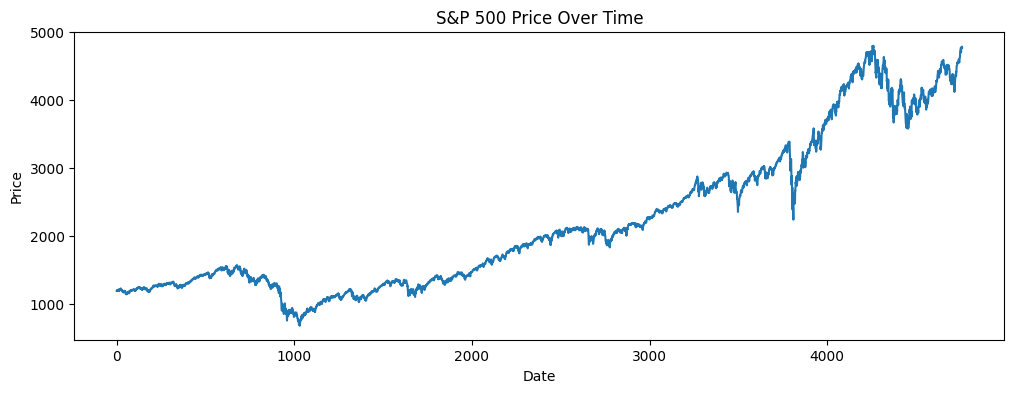

In [165]:
# Price Trend

plt.figure(figsize=(12,4))
plt.plot(df['Close'])
plt.title("S&P 500 Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

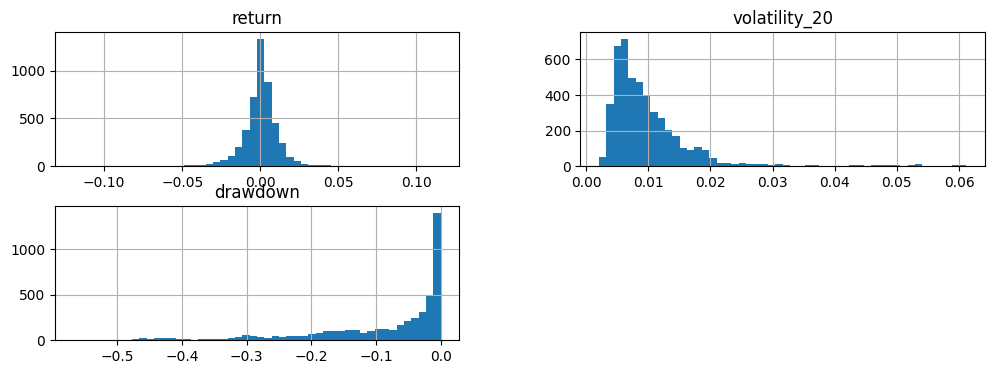

In [142]:
# Feature Visualization (Understanding the Data)

df[['return', 'volatility_20', 'drawdown']].hist(
    figsize=(12,4), bins=50
)
plt.show()


# Regime Based

In [143]:
regimes = pd.read_csv("./outputs/regimes.csv")


In [144]:
df.columns

Index(['Close', 'return', 'volatility_20', 'ma_20', 'trend_strength',
       'momentum_5', 'drawdown'],
      dtype='object')

In [145]:
regimes.columns

Index(['Date', 'return', 'volatility', 'drawdown', 'regime'], dtype='object')

In [146]:
df = df.reset_index()


In [147]:
df.columns

Index(['Date', 'Close', 'return', 'volatility_20', 'ma_20', 'trend_strength',
       'momentum_5', 'drawdown'],
      dtype='object')

In [148]:
print(df['Date'].dtype)
print(regimes['Date'].dtype)


datetime64[ns]
object


In [149]:
df['Date'] = pd.to_datetime(df['Date'])
regimes['Date'] = pd.to_datetime(regimes['Date'])

In [150]:
print(df['Date'].dtype)
print(regimes['Date'].dtype)


datetime64[ns]
datetime64[ns]


In [151]:
df = df.merge(
    regimes[['Date', 'regime']],
    on='Date',
    how='inner'
)


In [152]:
df[['Date', 'regime']].head()

,Date,regime
0,2005-02-01,0
1,2005-02-02,0
2,2005-02-03,0
3,2005-02-04,1
4,2005-02-07,0


In [153]:
df['regime'].value_counts()

,count
regime,
1,3301
0,1169
2,291


## Target


In [154]:
df['future_drawdown'] = df['drawdown'].shift(-1)

In [155]:
df['risk_target'] = (df['future_drawdown'] < -0.02).astype(int)

In [156]:
df.sample(5)

,Date,Close,return,volatility_20,ma_20,trend_strength,momentum_5,drawdown,regime,future_drawdown,risk_target
627,2007-07-31,1455.270020,-0.012647,0.010818,1520.768494,-0.002105,-0.037057,-0.062978,1,-0.056192,1
4034,2021-02-10,3909.879883,-0.000345,0.010467,3830.095520,0.001421,0.020691,-0.001458,1,0.000000,0
2159,2013-08-29,1638.170044,0.001963,0.006071,1670.111005,-0.002053,-0.011256,-0.041821,1,-0.044863,1
1187,2009-10-19,1097.910034,0.009405,0.010879,1063.834991,0.001565,0.020223,-0.298527,0,-0.302904,1
2300,2014-03-24,1857.439941,-0.004865,0.006262,1862.041504,0.000264,-0.000669,-0.010969,1,-0.006613,0


# Next-day drawdown risk prediction (binary classification)

- 1 → High risk tomorrow (≥2% drawdown)

- 0 → Normal conditions

- Binary
 & Intuitive: Risk-focused

In [157]:
features = [
    'regime',
    'volatility_20',
    'trend_strength',
    'momentum_5'
]

X = df[features]
y = df['risk_target']


- regime → Market environment (calm / volatile / crisis)
- volatility_20 → Current risk intensity
- trend_strength → Is the market trending or weakening?
- momentum_5 → Short-term directional pressure

**Condition risk prediction on both current regime and market dynamics**

In [158]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    shuffle=False
)


In [159]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [160]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [161]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.74      0.60      0.67       445
           1       0.79      0.88      0.83       746

    accuracy                           0.77      1191
   macro avg       0.77      0.74      0.75      1191
weighted avg       0.77      0.77      0.77      1191

ROC AUC: 0.8629273729553875


In [162]:
coefficients = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coefficients


,Feature,Coefficient
1,volatility_20,3.793446
2,trend_strength,-0.083148
0,regime,-0.823399
3,momentum_5,-0.878395


- volatility_20   +3.79   → strongest risk driver
- regime          -0.82   → regimes matter a lot
- momentum_5      -0.87   → negative momentum increases risk
- trend_strength  -0.08   → weaker but still informative


**Volatility is the strongest predictor of drawdown risk, but regime information significantly improves prediction, confirming that risk behaves differently across market states.**

## Market regime is one of the strongest predictors of future drawdown risk.

In [163]:
X_no_regime = df[
    ['volatility_20', 'trend_strength', 'momentum_5']
]

X_train_nr, X_test_nr, y_train, y_test = train_test_split(
    X_no_regime, y,
    test_size=0.25,
    shuffle=False
)

scaler_nr = StandardScaler()
X_train_nr = scaler_nr.fit_transform(X_train_nr)
X_test_nr = scaler_nr.transform(X_test_nr)

model_nr = LogisticRegression(max_iter=1000)
model_nr.fit(X_train_nr, y_train)

roc_nr = roc_auc_score(y_test, model_nr.predict_proba(X_test_nr)[:, 1])


In [164]:
print("With regime:", roc_auc_score(y_test, y_prob))
print("Without regime:", roc_nr)


With regime: 0.8629273729553875
Without regime: 0.8564026869897883


Including market regime information improves predictive performance, validating the two-stage pipeline design.